STAT 4609: Homework 2
***
In this homework assignment you will be tasked with implementing logistic regression and a basic optimization method for estimating the regression parameters. Suppose we have some inputs $X \in \mathbb{R}^{N \times D}$ with $N$ observations and $D$ covariates. Our targets are $y \in \{0,1\}^{N}$. Our regression parameters are $\beta \in \mathbb{R}^{D}$ and the link function between our linear model $X\beta$ and the targets is the logistic function $\sigma(X\beta) = \frac{1}{1+\exp{\{-X\beta\}}}$. Assume that we have i.i.d. observations that follow a Bernoulli likelihood: $ L(\beta) = \prod_{i=1}^{N} \sigma(X_i\beta)^{y_i} (1-\sigma(X_i\beta))^{1-y_i} $. Remember: In logistic regression you are maximizing the (log) likelihood.

1.) Write out the gradient of the log likelihood function with respect to the regression parameters, $\beta$. Please show your work and simplify the final answer as much as possible.

2.) Like the last homework assignment, please write a Python object containing the necessary functions to fit a logistic regression model. For numerical stability reasons, I have included a scipy implementation of the logistic function ("expit"). Read this article as to why we should use this function: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/. For this assignment we do not have to search for an optimal step size and we will just use a fixed constant step size.


In [1]:
# You may only use the base Python library and the following packages for the LogisticRegression class in your homework assignment.
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

class LogisticRegression(object):
    def __init__(self, X, Y):
        self.X, self.Y = self.addIntercept(X, X.shape[0]), Y
        self.n, self.p = self.X.shape
        self.beta = np.zeros(self.p) #regression parameters

    def addIntercept(self, X, n):
        return np.hstack((np.ones((n, 1)), X))

    def sigmoid(self, X):
        return expit(np.dot(X, self.beta)) #sigmoid
    
    def computeGradient(self):
        prob = self.sigmoid(self.X)
        gradient = np.dot(self.X.T, (self.Y - prob))
        return gradient
    
    def fit(self, step=.0001, num_iterations=10000):
        self.step, self.num_iterations = step, num_iterations
        log_likelihoods =[]
        
        for i in range(num_iterations):
            gradient = self.computeGradient() #log likelihood gradient
            self.beta += step * gradient #gradient ascent

            prob = self.sigmoid(self.X)
            log_likelihood = np.sum(self.Y * np.log(prob) + (1 - self.Y) * np.log(1 - prob))
            log_likelihoods.append(log_likelihood)

        return log_likelihoods
    
    def predict(self, X_test, threshold=0.5):
        X_test = self.addIntercept(X_test, X_test.shape[0])
        prob = self.sigmoid(X_test)
        return (prob >= threshold) #decision rule

3.) Use the synthetic data generated in the below cell to test out your logistic regression code. Generate a plot that shows the value of the log likelihood on the Y-axis and the iteration number on the X-axis. The log likelihood should increase as the number of iterations increases.

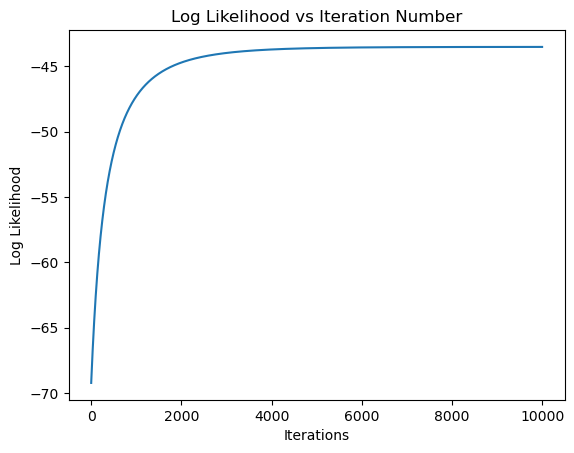

In [9]:
N = 100
D = 10
X = np.random.normal(size=(N,D))
beta0 = np.random.normal(size=D)
P = expit(X @ beta0)
Y = np.random.binomial(1,P)

# Fit logistic regression model
LR = LogisticRegression(X, Y)
log_likelihoods = LR.fit()

# Plot log likelihood vs iteration number
plt.plot(range(LR.num_iterations), log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs Iteration Number')
plt.show()

4.) Load the "breast_cancer_dataset" from scikit-learn and fit your logistic regression model on a training set consisting of the first 500 observations and evaluate the test set on the remaining data. One common metric to evaluate the test set performance of binary classifiers is looking at the confusion matrix of the predicted labels. The confusion matrix tells you the number of true positive / negative predictions as well as the false positive / negative predictions in your classifier. Plot the confusion matrix for your logistic regression classifier. You may use the decision rule that the test predictions with the probability that $P(y^{\ast} = 1 | X^{\ast} > .5$ are labeled "1". You are allowed to use the "confusion_matrix" function in scikit-learn for this problem.

Logistic Regression training time:  0.4818909168243408


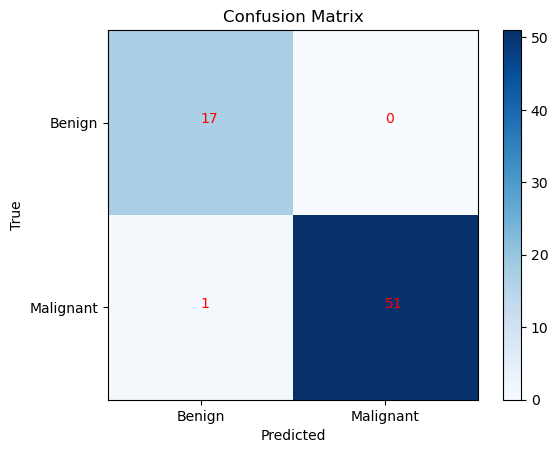

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
import time #to check how long the trainig takes for question 5
breast_cancer = load_breast_cancer()
X = breast_cancer['data']
# for numerical stability, standardize inputs
X -= X.mean(axis=0)
X /= X.std(axis=0)
# add intercept
X = np.hstack((X, np.ones((X.shape[0], 1))))
Y = breast_cancer['target']
X_train, X_test = X[:500], X[500:]
Y_train, Y_test = Y[:500], Y[500:]
LR = LogisticRegression(X=X_train,Y=Y_train)
start_time = time.time()
LR.fit(step=.0001)


end_time = time.time()
LR_training_time = end_time - start_time
print("Logistic Regression training time: ", LR_training_time)

#predict LR
Y_pred = LR.predict(X_test)

# Compute & plot confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'], title='Confusion Matrix', ylabel='True', xlabel='Predicted')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), color='red')
plt.show()

5.) Now write a class object to fit a naive Bayes classifier to the same breast cancer data set (you should notice that training an NB classifier should be a bit faster than in LR--it would be good to understand why). Evaluate your classifier on the same test set as in the above question and print the confusion matrix for your predicted labels. Compare how the naive Bayes classifier performs on the predicted labels compared to logistic regression.

In [4]:
class NaiveBayes:
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
        self.classes = np.unique(Y)
        self.params = []

    def fit(self):
        # Calculate the parameters for each class
        for i, c in enumerate(self.classes):
            X_c = self.X[self.Y == c]
            self.params.append({
                'prior': len(X_c) / len(X),
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0)
            })

    def log_likelihood(self, mean, var, x):
        return -0.5 * np.sum(np.log(2. * np.pi * var) + (x - mean) ** 2 / var)

    def predict(self, X_test):
        predictions =[]
        for x in X_test:
            log_posteriors = []
            for i, c in enumerate(self.classes):
                log_prior = np.log(self.params[i]['prior'])
                log_likelihood = self.log_likelihood(self.params[i]['mean'], self.params[i]['var'], x)
                log_posteriors.append(log_prior + log_likelihood)
            predictions.append(self.classes[np.argmax(log_posteriors)])
        return np.array(predictions)

Logistic Regression training time:  0.7486271858215332
Naive Bayes training time:  0.00036406517028808594 



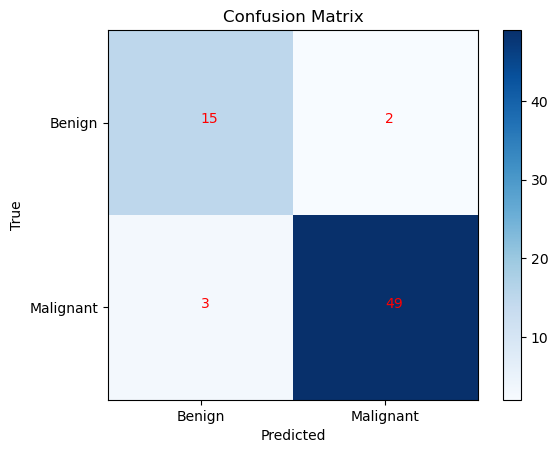

In [5]:
# train NB
NB = NaiveBayes(X=X_train,Y=Y_train)
start_time = time.time()
NB.fit()
end_time = time.time()
NB_training_time = end_time - start_time
print("Logistic Regression training time: ", LR_training_time)
print("Naive Bayes training time: ", NB_training_time,"\n")

#predict NB
Y_pred = NB.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Compute & plot confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'], title='Confusion Matrix', ylabel='True', xlabel='Predicted')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), color='red')
plt.show()